Explore mean sea level in nowcast and nowcast-green

In [1]:
import datetime
import numpy as np
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import glob

from nowcast.figures import shared, figures
from nowcast import analyze
from salishsea_tools import viz_tools
%matplotlib inline

In [2]:
def load_model_ssh(grid):
    ssh = grid.variables['sossheig'][:]
    time = grid.variables['time_counter']
    dates=nc.num2date(time[:], time.units)
    return ssh, dates

In [3]:
nowcast = '/results/SalishSea/nowcast/'
nowcast_green = '/results/SalishSea/nowcast-green/'
location = 'PointAtkinson'
tides_path = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/'
labels={nowcast: 'nowcast', nowcast_green: 'nowcast-green'}

grid_B = {}
grid_B[nowcast] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
grid_B[nowcast_green] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
mesh_mask = {}
mesh_mask[nowcast] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
mesh_mask[nowcast_green] = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')

runs = [nowcast, nowcast_green]

In [4]:
def load_ssh_time_series(d1,d2, runs):
    
    numdays = (d2-d1).total_seconds()/86400
    dates = [d1 + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

    ssh = {}
    time = {}
    for run in runs:
        d = dates[0]
        fname = glob.glob(os.path.join(run, d.strftime('%d%b%y').lower(), '*_1d_*_grid_T.nc'))[0]
        grid = nc.Dataset(fname)
        ssh[run], time[run] = load_model_ssh(grid)
        for d in dates[1:]:
            fname = glob.glob(os.path.join(run, d.strftime('%d%b%y').lower(), '*_1d_*_grid_T.nc'))[0]
            grid = nc.Dataset(fname)
            s,t = load_model_ssh(grid)
            ssh[run]=np.concatenate((ssh[run],s))
            time[run]=np.concatenate((time[run],t))
        tmask = mesh_mask[run].variables['tmask'][:,0,:,:]
        ssh[run] = np.ma.array(ssh[run], mask = np.ones(ssh[run].shape) - tmask)
    return ssh, time

# Sept 11 to 26, 2016

In [5]:
sdt = datetime.datetime(2016,9,11)
edt = datetime.datetime(2016,9,26)

ssh, time = load_ssh_time_series(sdt, edt, runs)

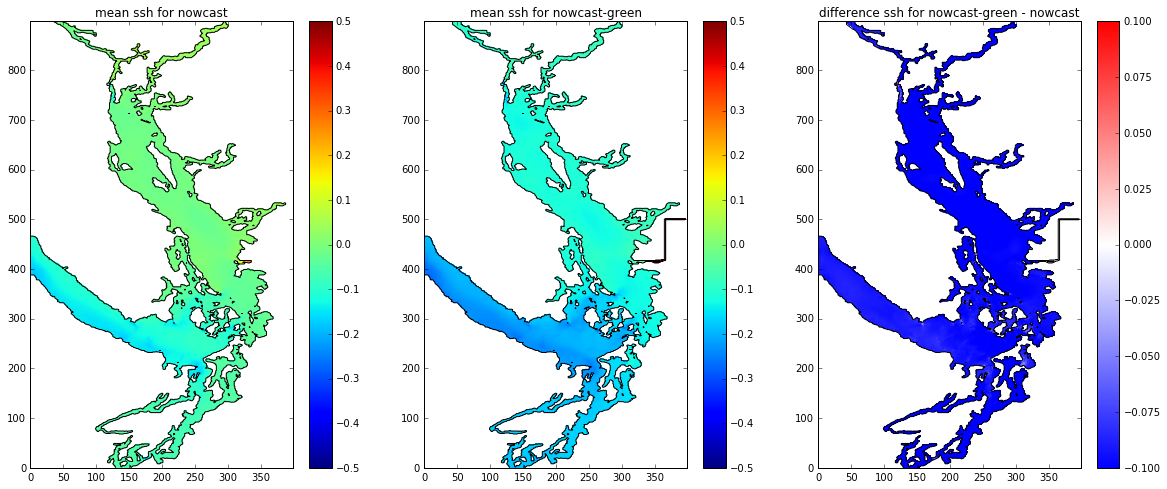

In [6]:
fig,axs = plt.subplots(1,3,figsize=(20,8))
for run, ax in zip(runs, axs):
    mesh=ax.pcolormesh(ssh[run].mean(axis=0),vmin=-.5,vmax=.5)
    plt.colorbar(mesh,ax=ax)
    ax.set_title('mean ssh for {}'.format(labels[run]))
    viz_tools.plot_coastline(ax, grid_B[run])
ax=axs[-1]
diff = ssh[nowcast_green].mean(axis=0) - ssh[nowcast].mean(axis=0)
mesh=ax.pcolormesh(diff,vmin=-.1,vmax=.1,cmap='bwr')
plt.colorbar(mesh,ax=ax)
ax.set_title('difference ssh for {} - {}'.format(labels[nowcast_green], labels[nowcast]))
viz_tools.plot_coastline(ax, grid_B[run])

In [7]:
for run in runs:
    print('{} mean ssh whole domain: {} m'.format(labels[run], np.mean(ssh[run])))

nowcast mean ssh whole domain: -0.05068201194654997 m
nowcast-green mean ssh whole domain: -0.14778545136372168 m


# Dec 12, 2015 to Sept 26, 2016

In [8]:
sdt = datetime.datetime(2015,12,12)
edt = datetime.datetime(2016,9,26)

ssh, time = load_ssh_time_series(sdt, edt, runs)

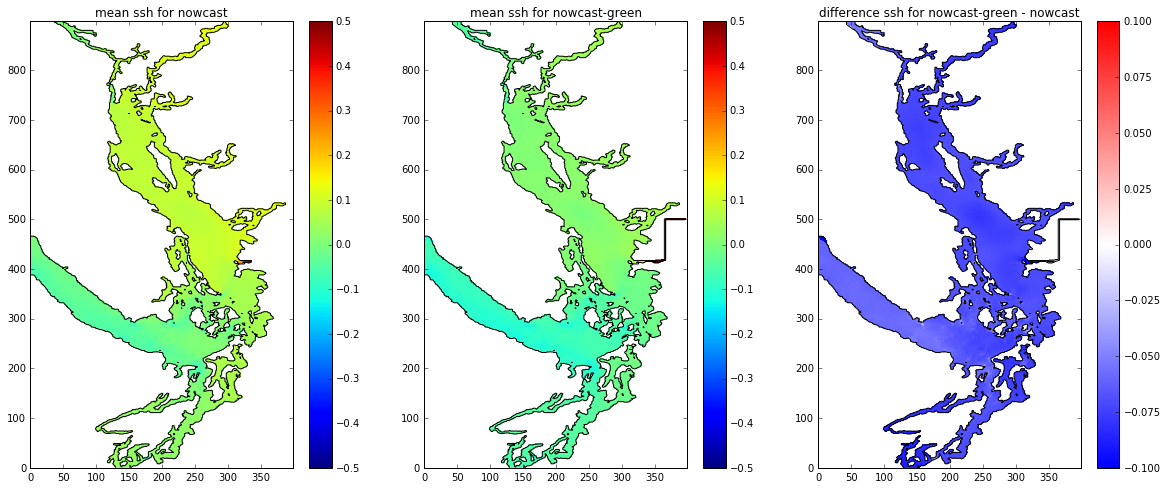

In [9]:
fig,axs = plt.subplots(1,3,figsize=(20,8))
for run, ax in zip(runs, axs):
    mesh=ax.pcolormesh(ssh[run].mean(axis=0),vmin=-.5,vmax=.5)
    plt.colorbar(mesh,ax=ax)
    ax.set_title('mean ssh for {}'.format(labels[run]))
    viz_tools.plot_coastline(ax, grid_B[run])
ax=axs[-1]
diff = ssh[nowcast_green].mean(axis=0) - ssh[nowcast].mean(axis=0)
mesh=ax.pcolormesh(diff,vmin=-.1,vmax=.1,cmap='bwr')
plt.colorbar(mesh,ax=ax)
ax.set_title('difference ssh for {} - {}'.format(labels[nowcast_green], labels[nowcast]))
viz_tools.plot_coastline(ax, grid_B[run])

In [10]:
for run in runs:
    print('{} mean ssh whole domain: {} m'.format(labels[run], np.mean(ssh[run])))

nowcast mean ssh whole domain: 0.04353379492871398 m
nowcast-green mean ssh whole domain: -0.0231548046500688 m


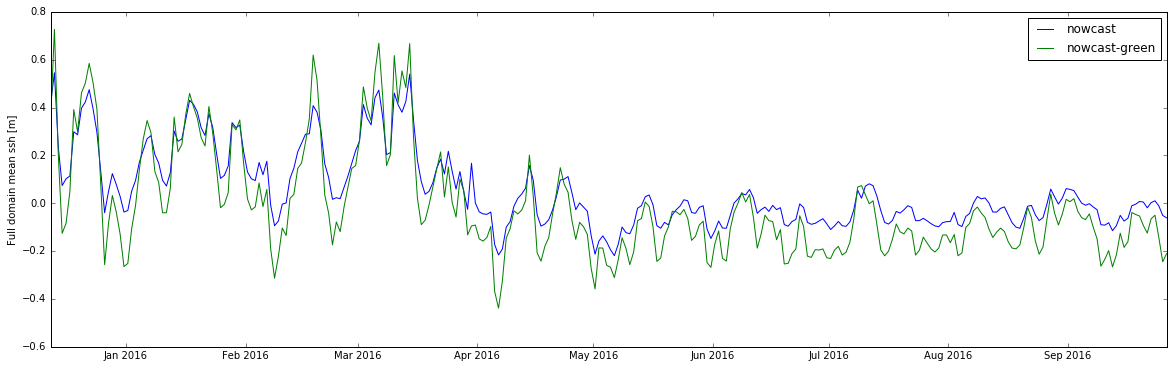

In [11]:
fig,ax = plt.subplots(1,1,figsize=(20,6))
for run in runs:
    ax.plot(time[run],ssh[run].mean(axis=-1).mean(axis=-1),label=labels[run])
ax.legend()
ax.set_ylabel('Full domain mean ssh [m]')

Why is nowcast-green mean ssh so much lower? Rivers??